# Anchor vs Anchorless Approach to Object Detection

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

## Anchor Approach

Given an image of shape `(H, W)`, we generate anchor boxes with different shapes centered on each pixel of the image. 

- Let scale be $s \in (0, 1]$
- Let ratio be $r \in (0, 1) = \frac{H}{W}$

We can define multiple anchor boxes using

$$
(H^\prime, W^\prime) = (Hs \sqrt{r}, Hs\frac{1}{\sqrt{r}})
$$


Why do we square roo the aspect ratio?

> By representing the aspect ratio as the square root of the ratio of width to height, we can reduce the number of aspect
> ratios that we need to consider while still providing a reasonable range of variation in aspect ratios. This can help to
> improve the performance of object detection algorithms by reducing the number of anchor boxes needed and allowing the
> algorithm to focus on more relevant aspect ratios.

### Number of Anchors

If we were to use `N` scales, and `M` ratios, we will have `H*W*N*M` many anchor boxes. Although these anchor boxes may cover all the ground truth bounding boxes, the computational complexity is easily too high. In practice, we can only consider those combinations containing `scales[0]` or `ratios[0]`. 

```
(scales[0], ratios[0]), (scales[0], ratios[1]), ..., (scales[0], ratios[-1])
```

and

```
(scales[1], ratios[0]), (scales[2], ratios[0]), ..., (scales[-1], ratios[0])
```

That is to say, the number of anchor boxes centered on the same pixel is `N + M - 1`.

In [115]:
def multi_box_prior(image, scales, ratios):
    img_H, img_W = image.shape[0], image.shape[1]
    device, num_scales, num_ratios = image.device, len(scales), len(ratios)
    
    boxes_per_pixel = (num_scales + num_ratios - 1)
    scale_tensor = torch.tensor(scales, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_y, offset_x = 0, 0
    y_step_size = 1.0 / img_H  
    x_step_size = 1.0 / img_W

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(img_H, device=device) + offset_y) * y_step_size
    center_w = (torch.arange(img_W, device=device) + offset_x) * x_step_size

    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    aspect_ratio = float(img_H) / img_W
    # Generate N + M - 1 number of heights and widths
    anchor_W = torch.cat((scale_tensor * ratio_tensor[0], scales[0] * ratio_tensor[1:])) * aspect_ratio
    anchor_H = torch.cat((scale_tensor / ratio_tensor[0], scales[0] / ratio_tensor[1:]))
    
    # Divide by 2 to get half height and half width
    # Thus, we have -w/2, -h/2, +w/2, and +h/2.
    # Repeat(number of times along i aixs, and 1 time along j axis.
    anchor_manipulations = torch.stack((-anchor_W, -anchor_H, anchor_W, anchor_H)).T.repeat(img_H * img_W, 1) / 2
    
    # Create box centers for all pixels.
    # Anchors are (x_min, y_min, x_max, y_max)
    centers = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    anchors = centers + anchor_manipulations

    return anchors.reshape(img_H, img_W, boxes_per_pixel, -1)

Why multiply the `w` component by aspect ratio? Because `w` represents the x-axis. When we convert to image coordinate, we multiply `x_min

In [116]:
def show_anchors(img, anchors, labels=None, color=(255, 255, 0)):
    H, W, _ = img.shape
    for i, anchor in enumerate(anchors):
        x_min, y_min, x_max, y_max = anchor.detach().numpy()
        u_min, v_min = int(x_min * W), int(y_min * H)
        u_max, v_max = int(x_max * W), int(y_max * H)
        cv2.rectangle(img, (u_min, v_min), (u_max, v_max), color, 2)
        
    fig, axs = plt.subplots(figsize=(10, 10))
    axs.imshow(img)

Image shape torch.Size([640, 960, 3])
Anchor shape torch.Size([640, 960, 5, 4])


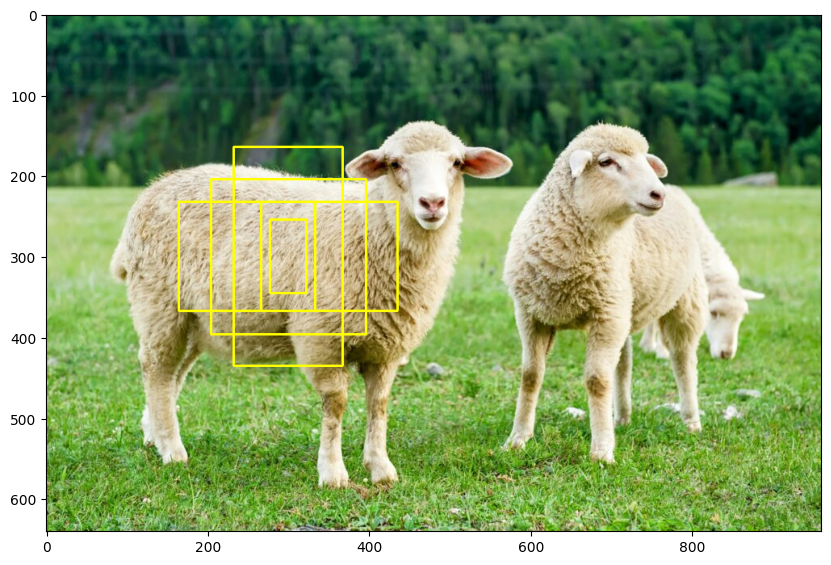

In [129]:
img = cv2.imread('assets/sheep.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.tensor(img)
print("Image shape", img.shape)
anchors = multi_box_prior(img, [0.30, 0.15, 0.10], np.sqrt([0.50, 1.0, 2.0]))
print("Anchor shape", anchors.shape)
show_anchors(img.detach().numpy(), anchors[300, 300, :, :])

Image shape torch.Size([640, 960, 3])
Anchor shape torch.Size([640, 960, 6, 4])


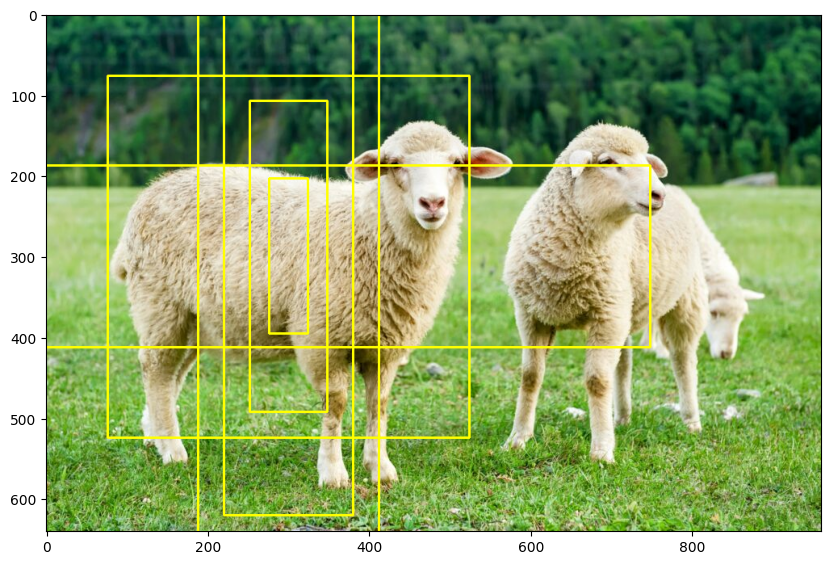

In [46]:
img = cv2.imread('assets/sheep.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.tensor(img)
print("Image shape", img.shape)
anchors = multi_box_prior(img, [0.70, 0.50, 0.30, 0.15], [0.50, 1.0, 2.0])
print("Anchor shape", anchors.shape)
show_anchors(img.detach().numpy(), anchors[300, 300, :, :])